# Metropolis Hastings

## Homework

### Last Week Gibbs Sampler (because I didn't make a histogram last time)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gamma, norm

In [355]:
C, G = 2, 10000
def gibbs_sampler_update(n, m, s, theta_0, tau_0, a, lmbda):

    x = stats.norm(loc=m, scale=s).rvs(size=n)
    theta = np.zeros((C, G))
    tau = np.zeros((C, G))
    theta[:, 0] = 1000
    
    for c in range(C):  
        for g in range(1, G):  
            alpha = a / 2 + n / 2
            rate = 0.5 * (np.sum((x - theta[c, g-1])**2) + lmbda)
            tau[c, g] = gamma(a=alpha, scale=1 / rate).rvs()
            
            mean = (n * tau[c,g] * np.mean(x) + tau_0 * theta_0) / (tau[c,g]*n + tau_0)

            var = 1 / (tau[c,g]*n + tau_0)
            theta[c, g] = norm(loc=mean, scale=np.sqrt(var)).rvs()
    
    return theta, tau

In [357]:
theta, tau = gibbs_sampler_update(30, 10, 1.0, 10, 50, 50, 50)

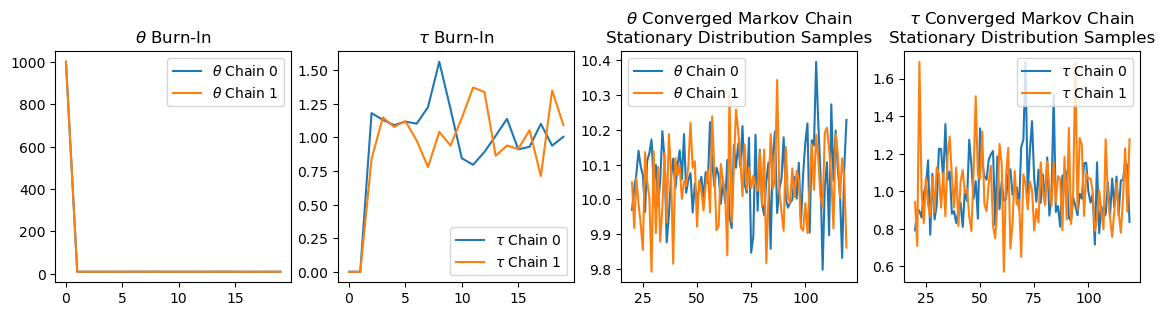

In [359]:
theta_burn = theta[:, burn:].flatten()
tau_burn = tau[:, burn:].flatten()

# 95% interval
lower1, upper1 = np.percentile(theta_burn, [2.5, 97.5])
lower2, upper2 = np.percentile(tau_burn, [2.5, 97.5])

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 

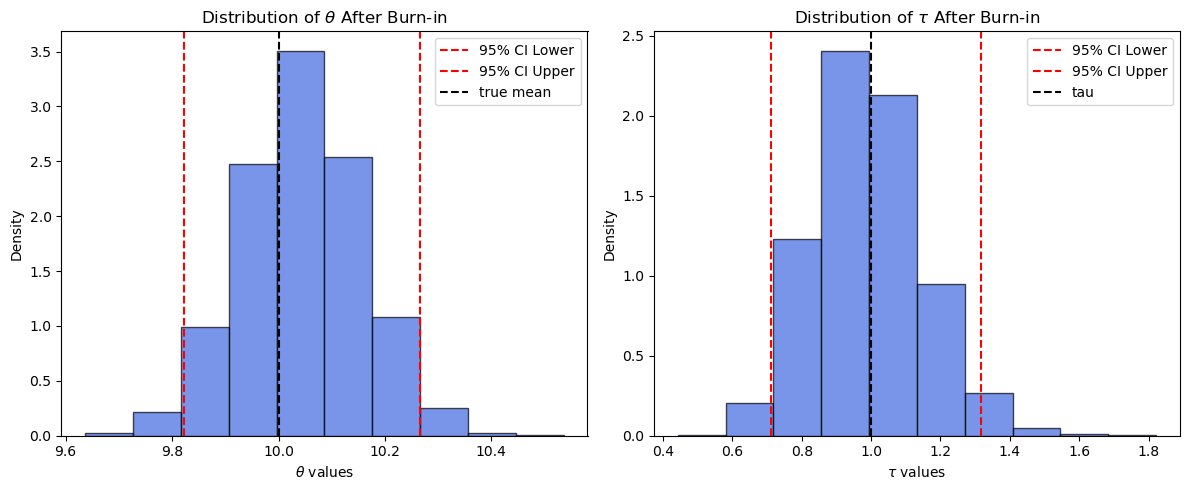

In [360]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Theta histogram
ax[0].hist(theta_burn, bins=10, alpha=0.7, color='royalblue', edgecolor='black', density=True)
ax[0].axvline(lower1, color='red', linestyle='dashed', label="95% CI Lower")
ax[0].axvline(upper1, color='red', linestyle='dashed', label="95% CI Upper")
ax[0].axvline(10, color='black', linestyle='dashed', label="true mean")
ax[0].set_title("Distribution of $\\theta$ After Burn-in")
ax[0].set_xlabel("$\\theta$ values")
ax[0].set_ylabel("Density")
ax[0].legend()

# Tau histogram
ax[1].hist(tau_burn, bins=10, alpha=0.7, color='royalblue', edgecolor='black', density=True)
ax[1].axvline(lower2, color='red', linestyle='dashed', label="95% CI Lower")
ax[1].axvline(upper2, color='red', linestyle='dashed', label="95% CI Upper")
ax[1].axvline(1, color='black', linestyle='dashed', label="tau")
ax[1].set_title("Distribution of $\\tau$ After Burn-in")
ax[1].set_xlabel("$\\tau$ values")
ax[1].set_ylabel("Density")
ax[1].legend()

# Show plots
plt.tight_layout()
plt.show()

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

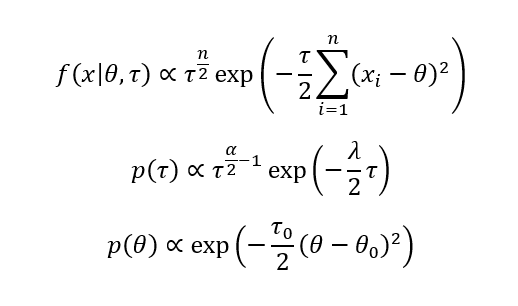

We calculate the joint by multiplying the likelihood, prior for tau, and prior for theta

In [339]:
# unnormalized joint posterior
def joint(n, theta, tau, x, theta0, tau0, alpha, lambd):
    # equations above 
    likelihood = tau**(n/2) * np.exp(-(tau/2) * np.sum((x - theta) ** 2 ))
    prior_tau = tau**(alpha/2 - 1) * np.exp(-(lambd/2) * tau)
    prior_theta = np.exp(-(tau0/2) * (theta - theta0)**2)

    return likelihood * prior_theta * prior_tau

In [340]:
def mh_gibbs(n, m, s, theta0, tau0, alpha, lambd):

    n = 30
    C, G = 2, 1000
    x = stats.norm(loc=m, scale=1/np.sqrt(s)).rvs(size=n) # generate using norm
    theta = np.zeros([C, G])
    tau = np.zeros([C, G])
    
    # initial arbitrary
    theta[:, 0] = 1
    tau[:, 0] = 1
    
    for c in range(C):
        for g in range(1, G):
        
            # update tau using MH
            
            tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c, g-1],
                                             scale=1/(tau_)**0.5).pdf(x)) * \
                                              stats.expon(scale=1).pdf(tau_)  

            tau_proposal = stats.expon(scale=2)
            tau_tilde = tau_proposal.rvs()
            
            # compute MH acceptance ratio
            mh_calc = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * \
                      (tau_proposal.pdf(tau[c, g-1]) / tau_proposal.pdf(tau_tilde))
            acceptance_probability = min(1, mh_calc)

            if stats.uniform().rvs() < acceptance_probability:
                tau[c, g] = tau_tilde # accept proposal
            else:
                tau[c, g] = tau[c, g-1] # reject proposal

            # update theta using MH
            
            theta_proposal = stats.norm(loc=theta[c, g-1], scale=10)
            theta_tilde = theta_proposal.rvs()
            
            # compute MH acceptance using joint function
            mh_calc = joint(n, theta_tilde, tau[c, g], x, theta0, tau0, alpha, lambd) / \
                joint(n, theta[c, g-1], tau[c, g], x, theta0, tau0, alpha, lambd)

            if np.random.rand() < min(1, mh_calc): 
                theta[c, g] = theta_tilde 
            else:
                theta[c, g] = theta[c, g-1]  
                
            
    return theta, tau

In [341]:
theta, tau = mh_gibbs(n=30, m=10, s=1, theta0=10, tau0=50, alpha=50, lambd=50)

# n: number of data points
# m: mean of data 
# s: precision
# theta0: prior mean theta
# tau0 : prior precision 
# alpha: shape for tau
# lambd: rate for tau


/tmp/ipykernel_53/2152703119.py:23: RuntimeWarning: invalid value encountered in scalar divide
  mh_calc = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * \
/tmp/ipykernel_53/2152703119.py:37: RuntimeWarning: invalid value encountered in scalar divide
  mh_calc = joint(n, theta_tilde, tau[c, g], x, theta0, tau0, alpha, lambd) / \
/tmp/ipykernel_53/2152703119.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  mh_calc = joint(n, theta_tilde, tau[c, g], x, theta0, tau0, alpha, lambd) / \


In [352]:
burn = 100
demo = 999
theta_burn = theta[:, burn:].flatten()
tau_burn = tau[:, burn:].flatten()

# 95% interval
lower1, upper1 = np.percentile(theta_burn, [2.5, 97.5])
lower2, upper2 = np.percentile(tau_burn, [2.5, 97.5])
print("95% Confidence Interval for theta after burn:", (lower1, upper1))
print("95% Confidence Interval for tau after burn:", (lower2, upper2))

# average of theta and tau after burn
print("theta average", theta_burn.mean())
print("tau average", tau_burn.mean())

95% Confidence Interval for theta after burn: (9.763320905503665, 10.146153147547844)
95% Confidence Interval for tau after burn: (0.5602114030559979, 1.5419199891768034)
theta average 9.997563271492016
tau average 0.9838653749969395


The true mean and true thetea are both in the intervals. (10 and 1)
The averages are also close to the true ones.

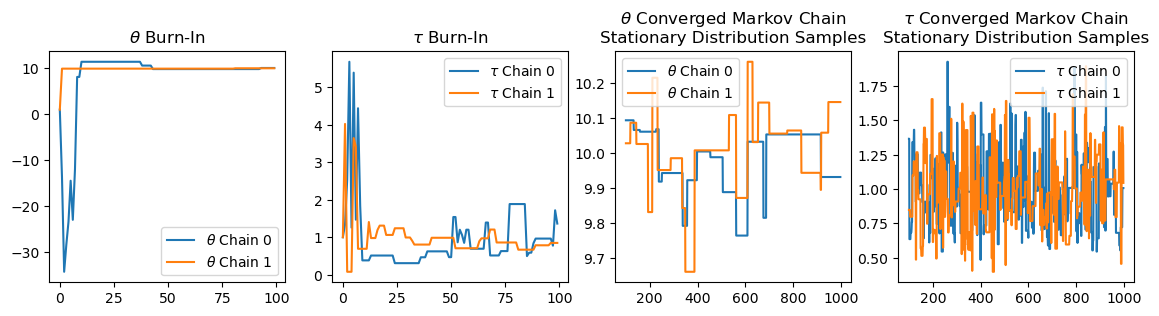

In [343]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
for c in range(2):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 

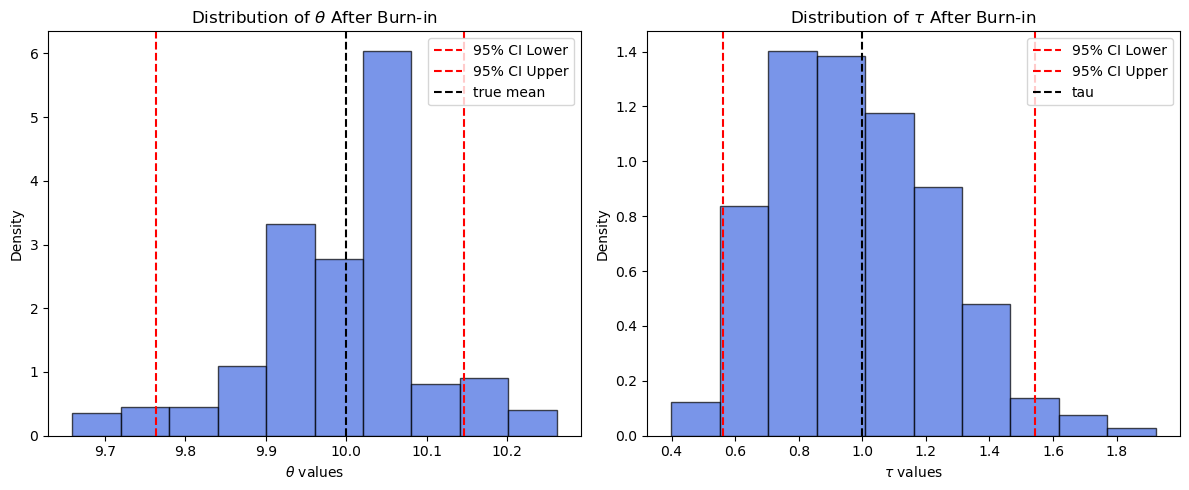

In [351]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Theta histogram
ax[0].hist(theta_burn, bins=10, alpha=0.7, color='royalblue', edgecolor='black', density=True)
ax[0].axvline(lower1, color='red', linestyle='dashed', label="95% CI Lower")
ax[0].axvline(upper1, color='red', linestyle='dashed', label="95% CI Upper")
ax[0].axvline(10, color='black', linestyle='dashed', label="true mean")
ax[0].set_title("Distribution of $\\theta$ After Burn-in")
ax[0].set_xlabel("$\\theta$ values")
ax[0].set_ylabel("Density")
ax[0].legend()

# Tau histogram
ax[1].hist(tau_burn, bins=10, alpha=0.7, color='royalblue', edgecolor='black', density=True)
ax[1].axvline(lower2, color='red', linestyle='dashed', label="95% CI Lower")
ax[1].axvline(upper2, color='red', linestyle='dashed', label="95% CI Upper")
ax[1].axvline(1, color='black', linestyle='dashed', label="tau")
ax[1].set_title("Distribution of $\\tau$ After Burn-in")
ax[1].set_xlabel("$\\tau$ values")
ax[1].set_ylabel("Density")
ax[1].legend()

# Show plots
plt.tight_layout()
plt.show()



Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).


The MH-Gibbs added the MH step to the Gibbs version from last week. This changed how theta and tau are udpated. 

In Gibbs, we used direct sampling from the full conditional distribution.

In contrast for the MH-Gibbs, instead of directly sampling from the full conditional distribution, we made new proposals (tau from the exponential and theta from the normal). The proposal was then either accepted or rejected based on the acceptance ratio.

This impacted the speed of which the data converged to their true values. The MH-Gibbs is significantly slower because of the rejected proposals. When proposals are rejected, it is not changed so it takes longer to converge.
In the Gibbs sample from last week, theta converged from the initial 1000 to 10 very quickly (in less than 5 iterations). The burn was only 20.
However for the MH-Gibbs, we started with an initial of 0 (which is closer to theta0), took almost 50 iterations to converge. 
This would also take a lot more time if the initial is far off like 1000.

If we compare the histogram from Gibbs (top of notebook) and MH-Gibbs:
For Gibbs, the distribution of theta and tau are significantly more centered and have mroe of an even normal distribution shape.
In contrast for MH-Gibbs, it's all over the place and varies more. 

Conclusion: the Gibbs burn phase is quicker and after converging, and the data is moving more smooth with less extreme fluctuations.

Although MH-Gibbs is good for when the full conditional distribution is not easy to work with, since it is possible to work with in this case the Gibbs method is better.


### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*

### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example 
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$

#### Answer

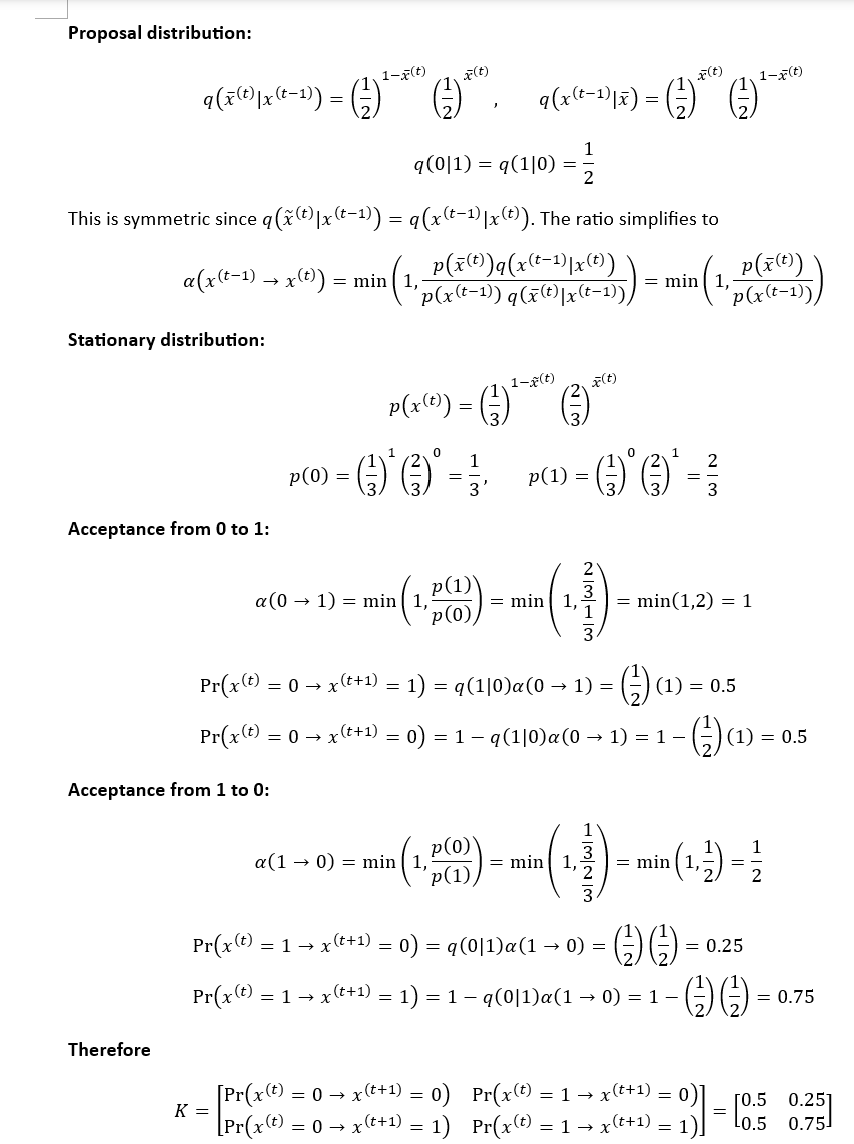

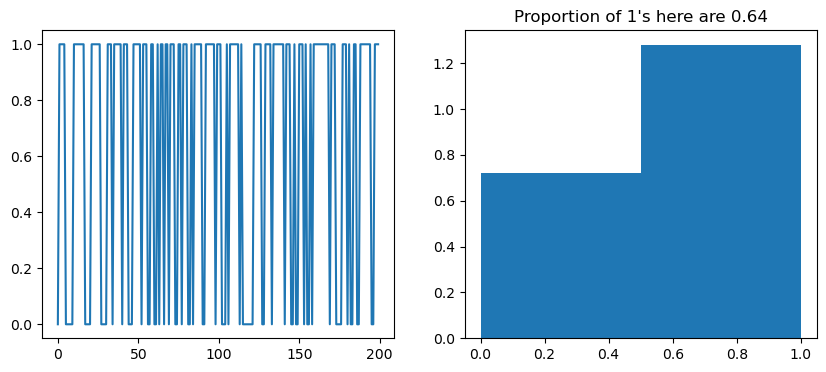

In [2]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]]) 
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

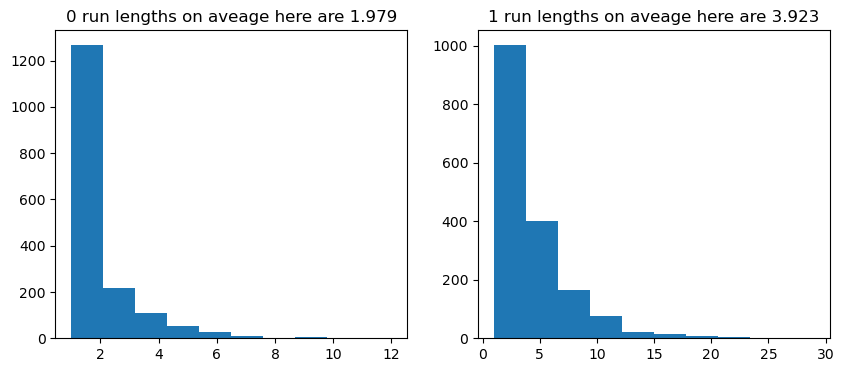

In [3]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));